# Opportunity Youth in South King County, updated with 2017 data

***
## Purpose of Analysis

This project offers an updated estimate of the number of Opportunity Youth in South King County using the 2017 5-year American Community Survey (ACS) Public Use Microdata Survey (PUMS).

Project goals:
1. Define who an opportunity youth is
2. Define South King County
3. Calculate and provide an estimate on the number of Opportunity Youth in south King County
4. Further Analysis and Breakdown

***
## 1. Who is an Opportunity Youth (OY)?

For our analysis, we define an opportunity youth is an individual who is:
- Between the ages of 16 and 24
- Not enrolled in any form of schooling
- Notemployed

## 2. What Areas Fall Within South King County

We looked at the Public Use Microdata Areas, or PUMAs, which are statistical georgraphic areas defined for the dissemination of Public Use Microdata Sample (PUMS) data.

We looked at the description of ea PUMA, along with where it layed on a map, to determine whether to include it within our analysis. We chose the following PUMAs within King County:

11610	King County (Central)--Renton City, Fairwood, Bryn Mawr & Skyway PUMA\
11611	King County (West Central)--Burien, SeaTac, Tukwila Cities & White Center PUMA\
11612	King County (Far Southwest)--Federal Way, Des Moines Cities & Vashon Island PUMA\
11613	King County (Southwest Central)--Kent City PUMA\
11614	King County (Southwest)--Auburn City & Lakeland PUMA\
11615	King County (Southeast)--Maple Valley, Covington & Enumclaw Cities PUMA

In [45]:
import folium
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt

In [46]:
coordinates = [47.5480, -121.9836] # South King County coordinates: 47.5480° N, 121.9836° W
kc_latitude = coordinates[0]
kc_longitude = coordinates[1]

King_County_WA_map = folium.Map([kc_latitude, kc_longitude]) # Create map object

df = gpd.read_file("../../data/shape_files/tl_2017_53_puma10.shp") # Download PUMA shapefile of Washington state 

df1 = df.loc[(df['PUMACE10'] == '11610') | (df['PUMACE10'] == '11611') | 
             (df['PUMACE10'] == '11612') | (df['PUMACE10'] == '11613') | 
             (df['PUMACE10'] == '11614') | (df['PUMACE10'] == '11615')] # Selecting areas of South King County

df1.to_file("df1.geojson", driver='GeoJSON') # Create .geojson file

overlay1 = os.path.join('df1.geojson') # Access the .geojson file

folium.GeoJson(overlay1).add_to(King_County_WA_map) # Overlay of two maps

King_County_WA_map

## 3. Calculating the Number of Opportunity Youth in South King County

The following bit of code will allow us to display our findings:

In [47]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

DBNAME = "opportunity_youth"

conn = psycopg2.connect(dbname=DBNAME)
cur = conn.cursor()

In [48]:
#Sample of the the PUMS 2017 table displayed below:

pd.read_sql("""SELECT *
            FROM pums_2017
            LIMIT 5;""", conn)

,rt,serialno,division,sporder,puma,region,st,adjinc,pwgtp,agep,...,pwgtp71,pwgtp72,pwgtp73,pwgtp74,pwgtp75,pwgtp76,pwgtp77,pwgtp78,pwgtp79,pwgtp80
0,P,2013000000006,9,01,11606,4,53,1061971,27.0,68.0,...,53.0,24.0,39.0,24.0,7.0,27.0,8.0,46.0,25.0,50.0
1,P,2013000000006,9,02,11606,4,53,1061971,22.0,66.0,...,49.0,21.0,38.0,20.0,7.0,25.0,8.0,41.0,22.0,47.0
2,P,2013000000012,9,01,10100,4,53,1061971,22.0,72.0,...,24.0,22.0,25.0,7.0,21.0,35.0,6.0,22.0,6.0,37.0
3,P,2013000000012,9,02,10100,4,53,1061971,19.0,64.0,...,21.0,18.0,19.0,7.0,17.0,29.0,6.0,19.0,6.0,29.0
4,P,2013000000038,9,01,11505,4,53,1061971,4.0,52.0,...,4.0,1.0,2.0,8.0,8.0,1.0,4.0,6.0,1.0,4.0


In addition to ages and PUMAs, we focused on the following columns from the above database to help us estiamte the number of OY in South King County (The bolded options were used within our analysis):

#### sch = School Enrollment
b .N/A (less than 3 years old)\
***1 .No, has not attended in the last 3 months***\
2 .Yes, public school or public college\
3 .Yes, private school or college or home school

#### esr = Employment Status Recode

b .N/A (less than 16 years old)\
1 .Civilian employed, at work\
2 .Civilian employed, with a job but not at work\
***3 .Unemployed***\
4 .Armed forces, at work\
5 .Armed forces, with a job but not at work\
***6 .Not in labor force***

In [49]:
#Filtering the database using all the conditions for an OY, within South King County:

df_oy_pums_2017 = pd.read_sql(
    """SELECT puma, pwgtp, agep, sch, schl, esr
    FROM pums_2017
    WHERE agep BETWEEN 16.0 AND 24.0
    AND puma IN ('11610', '11611', '11612', '11613', '11614', '11615')
    AND sch = '1'
    AND esr IN ('3','6')
    ORDER BY agep;""", conn)

In [50]:
df_oy_pums_2017.head()

,puma,pwgtp,agep,sch,schl,esr
0,11612,28.0,16.0,1,12,6
1,11614,45.0,16.0,1,12,6
2,11614,44.0,16.0,1,12,6
3,11611,12.0,16.0,1,01,6
4,11613,10.0,16.0,1,15,6


### Estimating the number of Opportunity Youth in South King County

In order to estimate the numuber of OY in South King County from the PUMS database above, we basically sum all the rows within the 'pwgtp' column, which is the weight per person applied to the total population.

In [61]:
skc_oy_2017 = df_oy_pums_2017.pwgtp.sum()
skc_oy_2017

10614.0

## 4. Further Analysis and Breakdown

- We further broke the data down to see the number of OY by PUMA within South King County
- Compared the number of OY in South King County between 2017 and 2016
- Breakdown of OYs by education achieived, age range, and ethnicity

### OY by PUMA within South King County

In [52]:
df_oy_pums_2017.groupby('puma')['pwgtp'].sum()

puma
11610    1853.0
11611    2038.0
11612    1977.0
11613    2006.0
11614    1530.0
11615    1210.0
Name: pwgtp, dtype: float64

In [53]:
PUMA_list = df1['PUMACE10'].tolist() # Creating list of PUMAs from South King County geodataframe and sorting in asc order
PUMA_list.sort()

Choropleth_map1_data = list(df_oy_pums_2017.groupby('puma')['pwgtp'].sum()) # Creating list of total number of OY per PUMA

df_choropleth_map1 = pd.DataFrame(list(zip(PUMA_list, Choropleth_map1_data)), columns =['PUMACE10', 'OY_of_SKC']) # Table

OY_by_PUMA_SKC = df1.merge(df_choropleth_map1, on='PUMACE10') # Add a column with the data into geodataframe

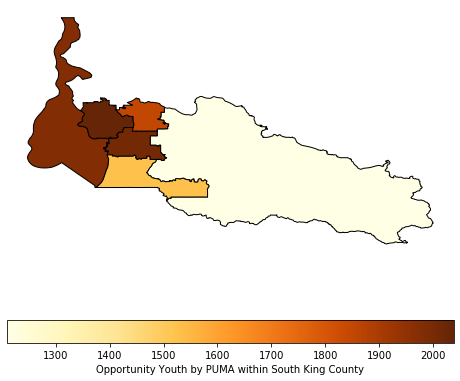

In [54]:
# Plot chotopleth map 

fig, ax = plt.subplots(figsize = (8,8))

Choropleth_map1 = OY_by_PUMA_SKC.plot(column='OY_of_SKC',
                                      ax=ax,
                                      legend = True,
                                      cmap='YlOrBr',
                                      figsize = (10, 15),
                                      legend_kwds={'label': "Opportunity Youth by PUMA within South King County",
                                                   'orientation': "horizontal",
                                                  },
                                      edgecolor = "black",
                                      );
Choropleth_map1.spines['top'].set_visible(False)
Choropleth_map1.spines['right'].set_visible(False)
Choropleth_map1.spines['bottom'].set_visible(False)
Choropleth_map1.spines['left'].set_visible(False)

Choropleth_map1.axes.get_xaxis().set_visible(False)
Choropleth_map1.axes.get_yaxis().set_visible(False)


matplotlib.rcParams['font.size'] = 15

### Number of OY in South King County in 2017 compared to 2016

In [62]:
#importing PUMS 2016 csv into a dataframe

df_pums_2016 = pd.read_csv('../../data/2016_pums/ss16pwa.csv')

#creating 2016 OY dataframe with our 2017 oy conditions (age, pumas, esr, sch)

df_oy_pums_2016 = df_pums_2016[df_pums_2016.AGEP.between(16, 24) & 
           df_pums_2016.PUMA.between(11610, 11615) & 
           df_pums_2016.ESR.isin([3,6]) & 
           (df_pums_2016.SCH == 1)].sort_values('AGEP')

skc_oy_2016 = df_oy_pums_2016.PWGTP.sum()
skc_oy_2016

11705

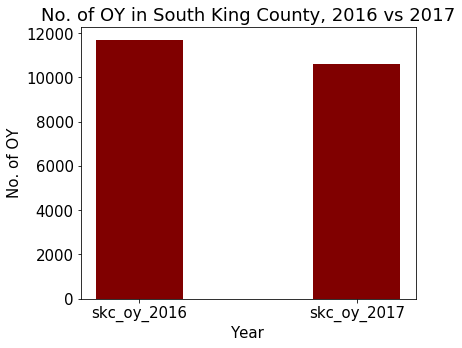

In [73]:
#Plotting the difference between the number of OY in South King County in 2017 vs 2016

skc_oy_2016_vs_2017 = {} #Creating a dictionary where keys = year, and the values = number of OY in ea year.

for year in ['skc_oy_2016', 'skc_oy_2017']: #This for-loop accomplishes the above.
    skc_oy_2016_vs_2017[year] = int(eval(year))

years = list(skc_oy_2016_vs_2017.keys()) #Split keys and values for plotting
oy = list(skc_oy_2016_vs_2017.values()) 
   
fig = plt.figure(figsize = (6, 5)) 
  
plt.bar(years, oy, color ='maroon',  
        width = 0.4) # creating the bar plot 
  
plt.xlabel("Year") 
plt.ylabel("No. of OY") 
plt.title("No. of OY in South King County, 2016 vs 2017") 
plt.show()

The number of OY in South County Decreased from 11705 in 2016 to 10614 in 2017.

That is a decrease of 9.3%

### Breakdown of OYs by education achieived, age range, and ethnicity